# Deep Learning
### Part 3: Spam Classification using Recurrent Neural Networks

#### Package installation and Import statments

In [5]:
# !pip install pandas numpy matplotlib seaborn tensorflow scikit-learn warnings

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
import warnings
warnings.filterwarnings('ignore') # to remove any unnecessary warning mssage in output

#### 1. Data load and EDA

In [7]:
# My local file path were I have dowloaded the data from https://www.kaggle.com/datasets/team-ai/spam-text-message-classification
csv_path = '/Users/abhinavpaul/Desktop/Goals/Exec Edu/1. ISB AMPBA/Course Material/Term 3/2. DL/Assignment/Data/SPAM text message 20170820 - Data.csv'
df = pd.read_csv(csv_path, encoding='latin-1')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
if df.shape[0]==df.drop_duplicates().shape[0]:
    print("No Duplicates")
else:
    print("Duplicates found")
    print("Dropped {} Duplicates".format(df.shape[0]-df.drop_duplicates().shape[0]))
    df = df.drop_duplicates()

Duplicates found
Dropped 415 Duplicates


In [10]:
df.isna().sum()

Category    0
Message     0
dtype: int64

In [11]:
# max word ina  message 
test = df['Message'].apply(lambda x: len(x))
test.describe()

count    5157.000000
mean       79.228040
std        58.451149
min         2.000000
25%        36.000000
50%        61.000000
75%       118.000000
max       910.000000
Name: Message, dtype: float64

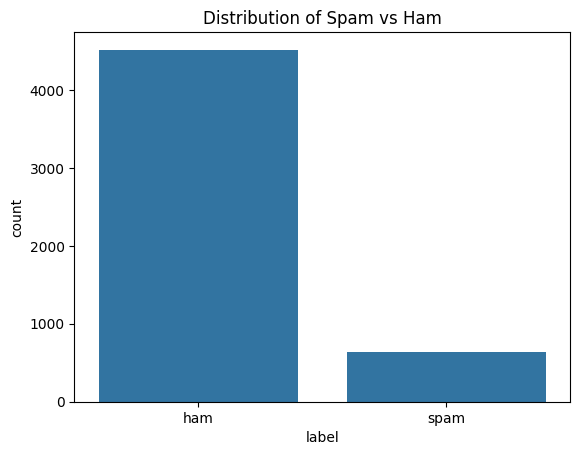

In [12]:
# Clean dataset (drop unnecessary cols)
df = df[['Category', 'Message']]
df.columns = ['label', 'text']

# Distribution
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham')
plt.show()

In [13]:
df.label.value_counts().reset_index().merge(df.label.value_counts(normalize=True).reset_index(), on='label')

,label,count,proportion
0,ham,4516,0.875703
1,spam,641,0.124297


#### 2. Preprocessing Data

In [14]:
# Convert labels to binary
labels = (df['label'] == 'spam').astype(int)  # Convert labels to binary values

# Tokenization
max_words = 5000  # Maximum number of words to consider ()
max_len = 100  # Maximum length of each text sequence
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')  # Tokenizer for text sequences
tokenizer.fit_on_texts(df['text'])  # Fit the tokenizer on the text sequences

sequences = tokenizer.texts_to_sequences(df['text'])  # Convert text sequences to sequences of word indices
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')  # Pad the sequences to have same length
y = labels.values  # Convert labels to numpy array

print('X shape:', X.shape)  
print('y shape:', y.shape)  

X shape: (5157, 100)
y shape: (5157,)


In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test sizes:', X_train.shape[0], X_test.shape[0])

Train/Test sizes: 4125 1032


In [16]:
label_mapping = {0: 'ham', 1: 'spam'}
counts = pd.DataFrame({'label': y_train}).label.value_counts().reset_index()
counts['label'] = counts['label'].map(label_mapping)
norm_counts = pd.DataFrame({'label': y_train}).label.value_counts(normalize=True).reset_index()
norm_counts['label'] = norm_counts['label'].map(label_mapping)
result_train = counts.merge(norm_counts, on='label')
result_train

,label,count,proportion
0,ham,3612,0.875636
1,spam,513,0.124364


In [17]:
label_mapping = {0: 'ham', 1: 'spam'}
counts = pd.DataFrame({'label': y_test}).label.value_counts().reset_index()
counts['label'] = counts['label'].map(label_mapping)
norm_counts = pd.DataFrame({'label': y_test}).label.value_counts(normalize=True).reset_index()
norm_counts['label'] = norm_counts['label'].map(label_mapping)
result_test = counts.merge(norm_counts, on='label')
result_test

,label,count,proportion
0,ham,904,0.875969
1,spam,128,0.124031


#### 3. Build RNN Model using Keras Sequential API

In [18]:
embedding_dim = 64
rnn_units = 64
dropout = 0.5
lr = 0.001

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    SimpleRNN(rnn_units, return_sequences=False),
    Dropout(dropout),
    Dense(1, activation='sigmoid') # used Sigmoid activation for binary classification
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

#### 4. Train Model and Evaluate on Test Data

In [19]:
epochs = 5
batch_size = 64

In [20]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8897 - loss: 0.3228
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9518 - loss: 0.1629
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9568 - loss: 0.1437
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9816 - loss: 0.0730
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9893 - loss: 0.0490


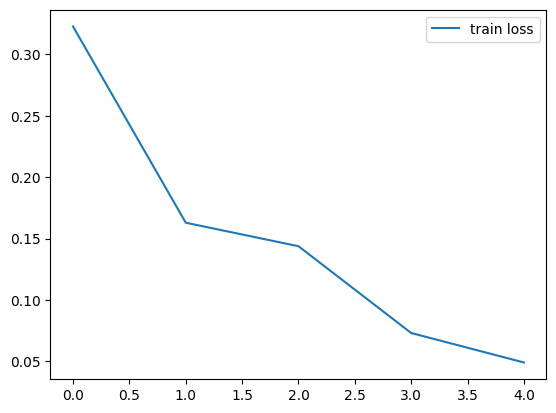

In [21]:
plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [22]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 Score:', f1)

cm = confusion_matrix(y_test, y_pred)
print ('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n', classification_report(y_test, y_pred))


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Accuracy: 0.9573643410852714
Precision: 0.9117647058823529
Recall: 0.7265625
F1 Score: 0.808695652173913

Confusion Matrix:
 [[895   9]
 [ 35  93]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       904
           1       0.91      0.73      0.81       128

    accuracy                           0.96      1032
   macro avg       0.94      0.86      0.89      1032
weighted avg       0.96      0.96      0.96      1032



#### 5. Experimentation with different hyperparameters and architectures

In [23]:
# Try SimpleRNN with diffent hyperparameters
epochs = 20
rnn_units = 128

print('SimpleRNN Model - Experiment')
model_simple_rnn = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    SimpleRNN(rnn_units, return_sequences=False),
    Dropout(dropout),
    Dense(1, activation='sigmoid')
])

model_simple_rnn.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

SimpleRNN Model - Experiment
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8655 - loss: 0.4093
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.8715 - loss: 0.3898
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8752 - loss: 0.3919
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.8756 - loss: 0.3864
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8759 - loss: 0.3777
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.8747 - loss: 0.3694
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8691 - loss: 0.3518
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9081 - loss: 0.2929
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8524 - loss: 0.3896
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.8589 - loss: 0.3876
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.8645 - loss: 0.3670
Epoch 12/20
65/65 ━━━━━━━━━━━━━━━━

In [24]:
# Evaluate SimpleRNN
y_pred_simple_rnn = (model_simple_rnn.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 Score:', f1)

cm = confusion_matrix(y_test, y_pred)
print ('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n', classification_report(y_test, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Accuracy: 0.9573643410852714
Precision: 0.9117647058823529
Recall: 0.7265625
F1 Score: 0.808695652173913

Confusion Matrix:
 [[895   9]
 [ 35  93]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       904
           1       0.91      0.73      0.81       128

    accuracy                           0.96      1032
   macro avg       0.94      0.86      0.89      1032
weighted avg       0.96      0.96      0.96      1032



In [25]:
# Try LSTM
print('LSTM Model - Experiment')
model_lstm = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    LSTM(rnn_units, return_sequences=False),
    Dropout(dropout),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

LSTM Model - Experiment
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 212ms/step - accuracy: 0.8672 - loss: 0.4029
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.8756 - loss: 0.3775
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 210ms/step - accuracy: 0.8756 - loss: 0.3790
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.8756 - loss: 0.3790
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.8756 - loss: 0.3818
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - accuracy: 0.8756 - loss: 0.3779
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.8756 - loss: 0.3792
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - accuracy: 0.8756 - loss: 0.3819
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.8756 - loss: 0.3800
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.8756 - loss: 0.3824
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.8756 - loss: 0.3802
Epoch 12/20
65/65

In [26]:
# Evaluate LSTM
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 Score:', f1)

cm = confusion_matrix(y_test, y_pred)
print ('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n', classification_report(y_test, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
Accuracy: 0.9573643410852714
Precision: 0.9117647058823529
Recall: 0.7265625
F1 Score: 0.808695652173913

Confusion Matrix:
 [[895   9]
 [ 35  93]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       904
           1       0.91      0.73      0.81       128

    accuracy                           0.96      1032
   macro avg       0.94      0.86      0.89      1032
weighted avg       0.96      0.96      0.96      1032



In [27]:
# Try GRU
print('GRU Model - Experiment')
model_gru = Sequential([
    Embedding(max_words, embedding_dim, input_length=max_len),
    GRU(rnn_units, return_sequences=False),
    Dropout(dropout),
    Dense(1, activation='sigmoid')
])

model_gru.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
history_gru = model_gru.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

GRU Model - Experiment
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.8647 - loss: 0.4046
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.8756 - loss: 0.3773
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.8756 - loss: 0.3807
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step - accuracy: 0.8756 - loss: 0.3801
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.8756 - loss: 0.3808
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.8756 - loss: 0.3789
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - accuracy: 0.8756 - loss: 0.3798
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.8756 - loss: 0.3808
Epoch 9/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 189ms/step - accuracy: 0.8756 - loss: 0.3774
Epoch 10/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.8756 - loss: 0.3788
Epoch 11/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.8756 - loss: 0.3814
Epoch 12/20
65/65 

In [28]:
# Evaluate GRU
y_pred_gru = (model_gru.predict(X_test) < 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', acc)
print('Precision:', prec)
print('Recall:', rec)
print('F1 Score:', f1)

cm = confusion_matrix(y_test, y_pred)
print ('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n', classification_report(y_test, y_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Accuracy: 0.9573643410852714
Precision: 0.9117647058823529
Recall: 0.7265625
F1 Score: 0.808695652173913

Confusion Matrix:
 [[895   9]
 [ 35  93]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       904
           1       0.91      0.73      0.81       128

    accuracy                           0.96      1032
   macro avg       0.94      0.86      0.89      1032
weighted avg       0.96      0.96      0.96      1032

